## Air Quality - Madrid (2001 - 2017)

Time series and prediction for the years 2018 and 2019

In [1]:
# import libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

%matplotlib inline

### Load and merge data (2001 to 2017). 

Not all dataframes have the same structure, I use pd.concat with axis=0 to end up with a dataframe containing all the columns from all the csv's files. NaN added for missing values.

In [2]:
df = pd.read_csv('data\csvs_per_year\madrid_2001.csv')

for year in range(2002, 2018):
    df_temp = pd.read_csv(f'data\csvs_per_year\madrid_{year}.csv')
    df = pd.concat([df, df_temp], axis = 0)

In [3]:
#set date column as index
df = pd.DataFrame(df, columns=list(df.columns)).set_index('date')

In [4]:
df.head() 

,BEN,CO,EBE,MXY,NMHC,NO_2,NOx,OXY,O_3,PM10,PXY,SO_2,TCH,TOL,station,PM25,NO,CH4
date,,,,,,,,,,,,,,,,,,
2001-08-01 01:00:00,NaN,0.37,NaN,NaN,NaN,58.400002,87.150002,NaN,34.529999,105.000000,NaN,6.34,NaN,NaN,28079001,NaN,NaN,NaN
2001-08-01 01:00:00,1.5,0.34,1.49,4.1,0.07,56.250000,75.169998,2.11,42.160000,100.599998,1.73,8.11,1.24,10.82,28079035,NaN,NaN,NaN
2001-08-01 01:00:00,NaN,0.28,NaN,NaN,NaN,50.660000,61.380001,NaN,46.310001,100.099998,NaN,7.85,NaN,NaN,28079003,NaN,NaN,NaN
2001-08-01 01:00:00,NaN,0.47,NaN,NaN,NaN,69.790001,73.449997,NaN,40.650002,69.779999,NaN,6.46,NaN,NaN,28079004,NaN,NaN,NaN
2001-08-01 01:00:00,NaN,0.39,NaN,NaN,NaN,22.830000,24.799999,NaN,66.309998,75.180000,NaN,8.80,NaN,NaN,28079039,NaN,NaN,NaN


In [5]:
df.tail()

,BEN,CO,EBE,MXY,NMHC,NO_2,NOx,OXY,O_3,PM10,PXY,SO_2,TCH,TOL,station,PM25,NO,CH4
date,,,,,,,,,,,,,,,,,,
2017-08-01 00:00:00,NaN,0.2,NaN,NaN,NaN,27.0,NaN,NaN,65.0,NaN,NaN,NaN,NaN,NaN,28079056,NaN,1.0,NaN
2017-08-01 00:00:00,NaN,0.2,NaN,NaN,NaN,14.0,NaN,NaN,NaN,73.0,NaN,7.0,NaN,NaN,28079057,NaN,1.0,NaN
2017-08-01 00:00:00,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,83.0,NaN,NaN,NaN,NaN,NaN,28079058,NaN,1.0,NaN
2017-08-01 00:00:00,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,28079059,NaN,1.0,NaN
2017-08-01 00:00:00,NaN,NaN,NaN,NaN,NaN,14.0,NaN,NaN,77.0,60.0,NaN,NaN,NaN,NaN,28079060,NaN,1.0,NaN


### Sort by dates

In [6]:
# convert date column from object to datetime type
df.index = pd.to_datetime(df.index)

# sort by date
df.sort_index(inplace=True)

### NaN values

In [7]:
# percentage of NaN values per column
df_nan = df.isna().mean().round(4) * 100
df_nan

BEN        72.59
CO         29.87
EBE        73.66
MXY        91.56
NMHC       71.20
NO_2        0.56
NOx        38.29
OXY        91.56
O_3        21.06
PM10       24.47
PXY        91.56
SO_2       26.52
TCH        71.17
TOL        72.67
station     0.00
PM25       78.67
NO         60.86
CH4        99.83
dtype: float64

From here it can be seen that MXY, OXY, PXY and CH4 are more than 90% NaN values. Also, BEN, EBE, NMHC, TCH, TOL and PM25 are more than 70% NaN values. Not much information will be drown from these pollutants. 

In this analysis I will look at NO2, O3, PM10 and SO2. In https://www.londonair.org.uk/LondonAir/nowcast.aspx only NO2, O3, PM10 and PM25 are reported.


In [8]:
df=df.drop(columns=['NO', 'BEN', 'EBE', 'MXY', 'NMHC', 'OXY', 'PXY', 'TCH', 'TOL', 'CH4', 'PM25','NOx', 'station'])
df.head()

,CO,NO_2,O_3,PM10,SO_2
date,,,,,
2001-01-01 01:00:00,1.45,50.389999,4.180000,21.219999,10.86
2001-01-01 01:00:00,1.25,55.290001,7.830000,30.559999,22.10
2001-01-01 01:00:00,0.87,53.400002,8.350000,36.669998,11.42
2001-01-01 01:00:00,0.79,47.320000,3.400000,14.440000,9.69
2001-01-01 01:00:00,0.67,43.820000,32.490002,11.890000,9.35


In [9]:
pollutants_nan_percentage = df.isna().mean().round(4)*100

<AxesSubplot:title={'center':'Percentage of NaN values'}, xlabel='Pollutant', ylabel='NaN percentage (%)'>

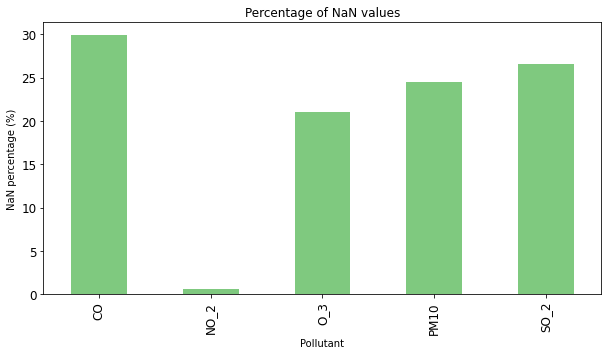

In [10]:
plt.figure(figsize=(10, 5))
pollutants_nan_percentage.plot(
    xlabel='Pollutant', 
    ylabel='NaN percentage (%)', 
    kind='bar', 
    title='Percentage of NaN values',
    fontsize = 12,
    colormap = 'Accent'
)


### Summary

In [11]:
df.describe().round(2)

,CO,NO_2,O_3,PM10,SO_2
count,2622414.00,3718224.00,2951683.00,2824344.00,2747374.00
mean,0.55,50.69,39.76,29.14,10.71
std,0.54,34.62,30.41,26.02,9.14
min,0.00,0.00,0.00,0.00,0.00
25%,0.26,24.00,12.65,11.75,5.90
50%,0.40,44.32,34.66,21.75,8.20
75%,0.65,69.90,59.74,38.00,12.36
max,18.04,628.60,236.00,695.00,199.10


There is a huge difference between Median and Maximum values. There must be outliers present. 

### Further data exploration

How widely is the data distributed?

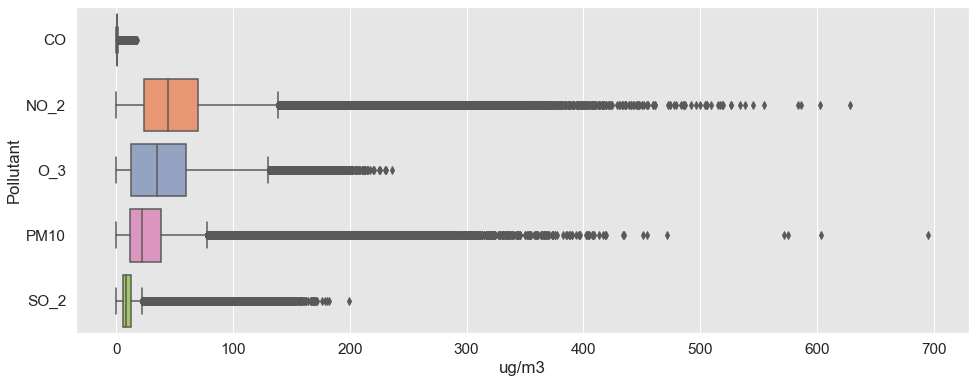

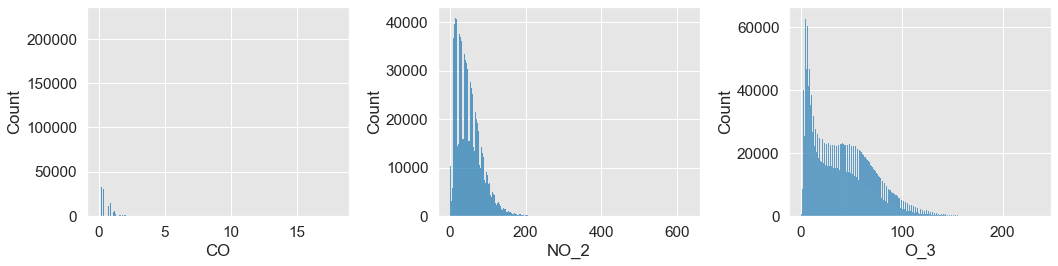

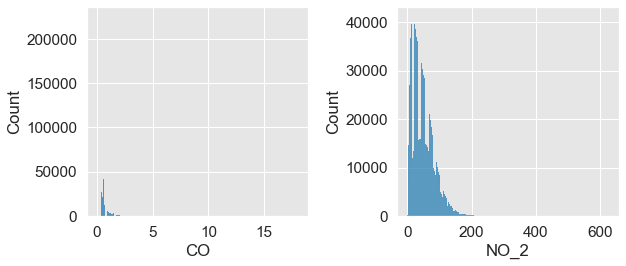

In [12]:
plt.figure(figsize=(16, 6))
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_context("notebook", font_scale=1.4)
plt.ylabel('Pollutant')
plt.xlabel('ug/m3')
ax = sns.boxplot(data=df, orient="h", palette="Set2")

fig, axs = plt.subplots(ncols=3,figsize=(15, 4))
sns.histplot(df, x="CO", ax=axs[0])
sns.histplot(df, x="NO_2",ax=axs[1])
sns.histplot(df, x="O_3",ax=axs[2])
plt.tight_layout()

fig, axs = plt.subplots(ncols=2,figsize=(9, 4))
sns.histplot(df, x="CO", ax=axs[0])
sns.histplot(df, x="NO_2",ax=axs[1])
plt.tight_layout()

From above, we find that there are too many high unexpected values. This is conditional to the inherent events within the city, where dense air pollution might have occured due to heavy traffic from huge number of vehicles.

Looking at maximum values per day

In [13]:
df_max_day = df.copy()
df_max_day.index = df.index.to_period('D')
df_max_day = df_max_day.groupby(by=df.index).max()
df_max_day.tail()

,CO,NO_2,O_3,PM10,SO_2
date,,,,,
2017-12-31 20:00:00,0.5,49.0,76.0,8.0,10.0
2017-12-31 21:00:00,0.5,67.0,80.0,11.0,10.0
2017-12-31 22:00:00,0.4,64.0,80.0,14.0,10.0
2017-12-31 23:00:00,0.4,42.0,84.0,16.0,10.0
2018-01-01 00:00:00,0.3,39.0,83.0,14.0,9.0


In [14]:
df_max_day.head()

,CO,NO_2,O_3,PM10,SO_2
date,,,,,
2001-01-01 01:00:00,3.62,81.360001,32.490002,98.379997,41.770000
2001-01-01 02:00:00,6.36,93.160004,22.850000,87.010002,51.950001
2001-01-01 03:00:00,4.97,90.059998,21.190001,159.399994,52.349998
2001-01-01 04:00:00,4.55,114.300003,22.270000,65.239998,41.980000
2001-01-01 05:00:00,4.16,87.599998,25.139999,75.000000,35.320000


<AxesSubplot:xlabel='SO_2', ylabel='Count'>

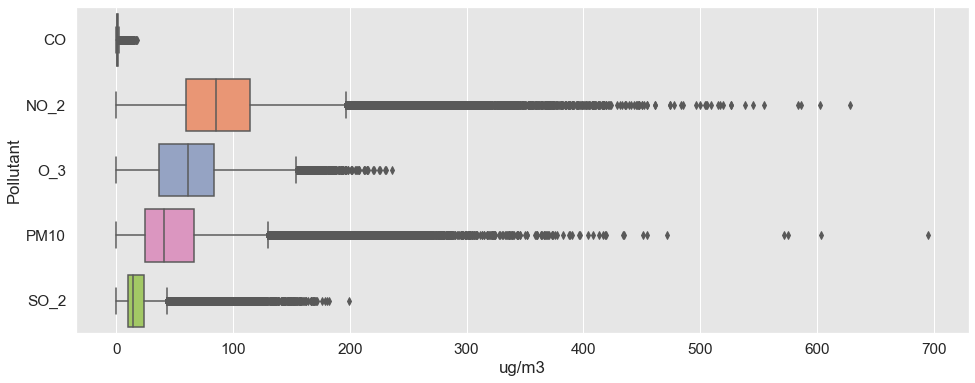

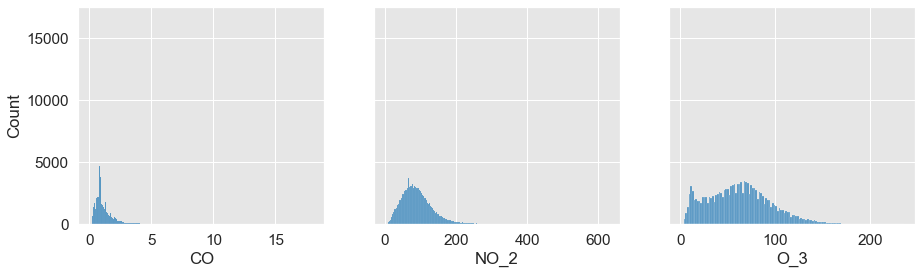

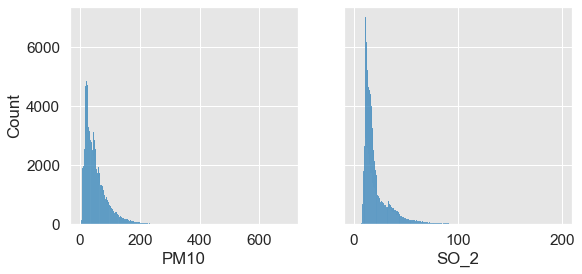

In [15]:

plt.figure(figsize=(16, 6))
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_context("notebook", font_scale=1.4)
plt.ylabel('Pollutant')
plt.xlabel('ug/m3')
ax = sns.boxplot(data=df_max_day, orient="h", palette="Set2")

fig, axs = plt.subplots(ncols=3,figsize=(15, 4), sharey=True)
sns.histplot(df_max_day, x="CO", ax=axs[0])
sns.histplot(df_max_day, x="NO_2",ax=axs[1])
sns.histplot(df_max_day, x="O_3",ax=axs[2])

fig, axs = plt.subplots(ncols=2,figsize=(9, 4), sharey=True)
sns.histplot(df_max_day, x="PM10", ax=axs[0])
sns.histplot(df_max_day, x="SO_2",ax=axs[1])

After aggregating, it is shown that the plots are bit more normalized in comparison to the previous ones, but still we find some outliers in this case.

In [17]:
# Monthly average - maximum value per day
df_monthAvg = df_max_day.copy()
df_monthAvg.index=df_monthAvg.index.to_period('M')
df_monthAvg = df_monthAvg.groupby(by=df_monthAvg.index).mean()
df_monthAvg.head()

,CO,NO_2,O_3,PM10,SO_2
date,,,,,
2001-01,2.649287,92.894213,36.389112,64.629139,55.997833
2001-02,2.793214,120.711458,37.276994,78.634777,61.140179
2001-03,1.894078,97.472840,50.184091,49.936662,44.464738
2001-04,1.523389,105.902320,64.472833,51.851417,39.445430
2001-05,1.747984,119.890887,67.371331,56.801304,32.479987


In [18]:
df_monthAvg.tail()

,CO,NO_2,O_3,PM10,SO_2
date,,,,,
2017-09,0.538750,76.843056,74.487500,30.598611,15.573611
2017-10,0.734005,93.145161,54.654570,35.794355,12.153226
2017-11,0.862222,104.704167,37.522222,35.045833,18.247222
2017-12,0.748253,90.095430,39.756720,28.939516,18.270161
2018-01,0.300000,39.000000,83.000000,14.000000,9.000000


### Series of the pollutants from Jan 2001 to Dec 2017
Monthly averaged from max per day

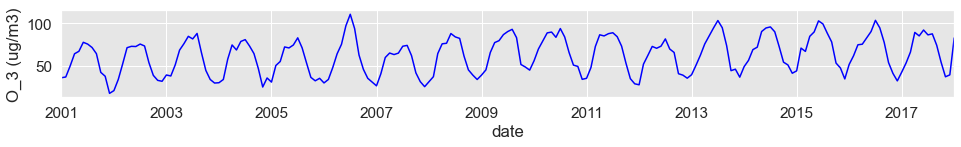

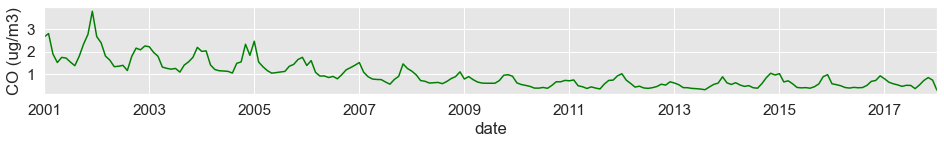

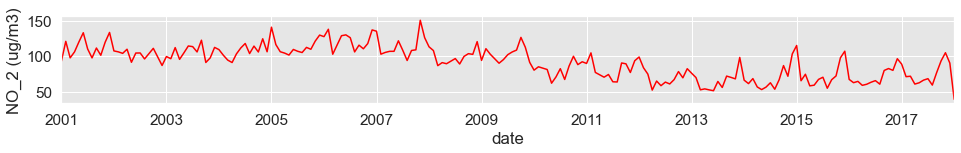

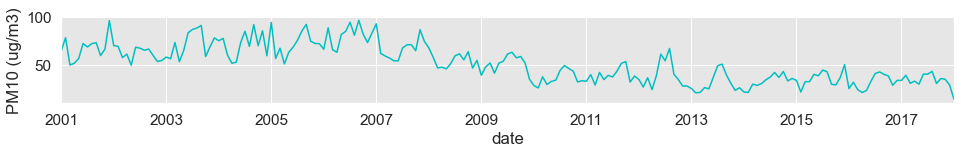

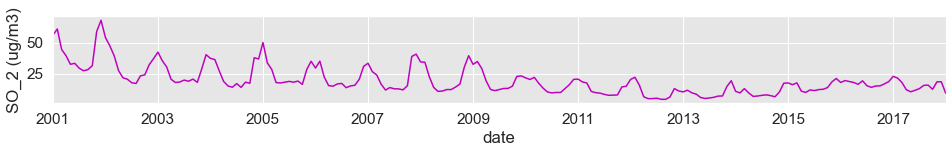

In [19]:
pollutants = ['O_3', 'CO', 'NO_2', 'PM10', 'SO_2']
colors = ['b', 'g', 'r', 'c', 'm']

for pollutant, color in zip(pollutants, colors):
    plt.figure(figsize=(16, 1.6))
    ax = df_monthAvg[pollutant].plot(color=color, y=pollutant)
    ax.set_ylabel(pollutant+' (ug/m3)')

### The combined effect of the pollutants
#### 1. Yearly moving average of the sum of the 5 pollutants

In [30]:
df_yearAvg = df.copy()
df_yearAvg.index = df_yearAvg.index.to_period('Y')
df_yearAvg = df_yearAvg.groupby(by=df_yearAvg.index).mean()

# drop 2018-01-01 00:00:000 readings, and sum all pollutants
df_yearAvg = df_yearAvg[:-1].sum(axis=1).to_frame()
df_yearAvg.rename(columns={df_yearAvg.columns[0]:'Avg_total_pollution'}, inplace=True)
df_yearAvg.index = df_yearAvg.index.to_timestamp()

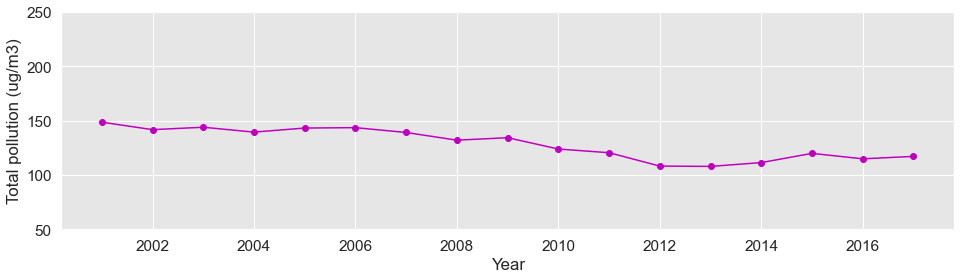

In [31]:
plt.figure(figsize=(16, 4))
plt.plot(df_yearAvg.index, df_yearAvg['Avg_total_pollution'],linestyle='-', marker='o', color='m')
plt.ylim(50, 250)

plt.ylabel('Total pollution (ug/m3)')
plt.xlabel('Year')
plt.show()

### The combined effect of the pollutants
#### 2. Monthly average over the years

In [46]:
df_monthAvg = df.copy()
df_monthAvg = df_monthAvg.groupby(by=df.index.month).mean()
df_monthAvg = df_monthAvg.sum(axis=1).to_frame()
df_monthAvg.rename(columns={df_monthAvg.columns[0]:'Avg_total_pollution'}, inplace=True)

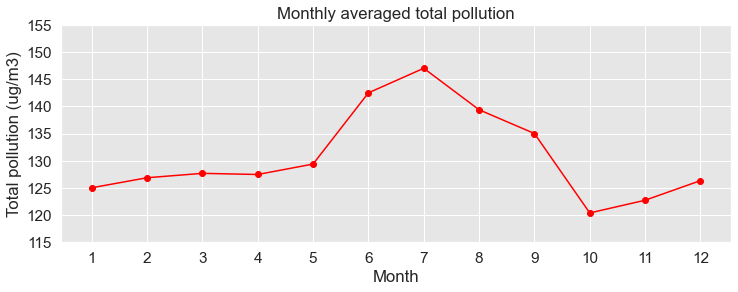

In [47]:
ax = df_monthAvg.plot(
        figsize=(12,4),
        linestyle='-', 
        marker='o', 
        title='Monthly averaged total pollution',
        legend=False,
        yticks=range(115,160,5),
        xticks=range(1,13),
        color='r'
    )

ax.set_ylabel('Total pollution (ug/m3)')
ax.set_xlabel('Month')
plt.show()

There is a spike of pollution between May and October, getting to a maximum every July.

### The combined effect of the pollutants
#### 3. Hourly average over the years

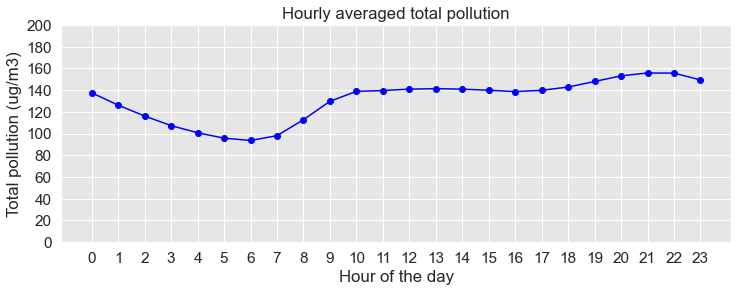

In [48]:
df_hourAvg = df.copy()
df_hourAvg = df_hourAvg.groupby(by=df.index.hour).mean()
df_hourAvg = df_hourAvg.sum(axis=1).to_frame()
df_hourAvg.rename(columns={df_hourAvg.columns[0]:'Avg_total_pollution'}, inplace=True)

ax = df_hourAvg.plot(
        figsize=(12,4),
        linestyle='-', 
        marker='o', 
        title='Hourly averaged total pollution',
        legend=False,
        yticks=range(0,210,20),
        xticks=range(24),
        color='b'
    )

ax.set_ylabel('Total pollution (ug/m3)')
ax.set_xlabel('Hour of the day')
plt.show()

While humans sleep at night, the air quality improves, until they start their human activities from 6-7 am.

### Forecasting

Forecasting will be performed for every pollutant. Also, it will be performed on the total (the sum).

#### 1. Ozone
Decomposition of ozone time series.

In [ ]:
df_2.head()